In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
df = yf.download('AAPL',start = '2018-01-01',end='2023-01-01')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.831589,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.824474,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.014107,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.481060,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.326996,82271200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.477127,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.652435,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.674026,85438400


In [4]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df=df.drop('Open',axis=1)
df=df.drop('Close',axis=1)
df=df.drop('Low',axis=1)
df=df.drop('Volume',axis=1)
df=df.drop('High',axis=1)
df

,Adj Close
Date,
2018-01-02,40.831589
2018-01-03,40.824474
2018-01-04,41.014107
2018-01-05,41.481060
2018-01-08,41.326996
...,...
2022-12-23,131.477127
2022-12-27,129.652435
2022-12-28,125.674026


In [6]:
from scipy.stats import zscore

df['z_score'] = np.abs(zscore(df))

df['outlier'] = df['z_score'] > 3

print(df[df['outlier']])

Empty DataFrame
Columns: [Adj Close, z_score, outlier]
Index: []


Here we have used a built in function for calculating the z-score from scipy.stats. Later we have considered the datapoints where the absolute z-score was above 3.

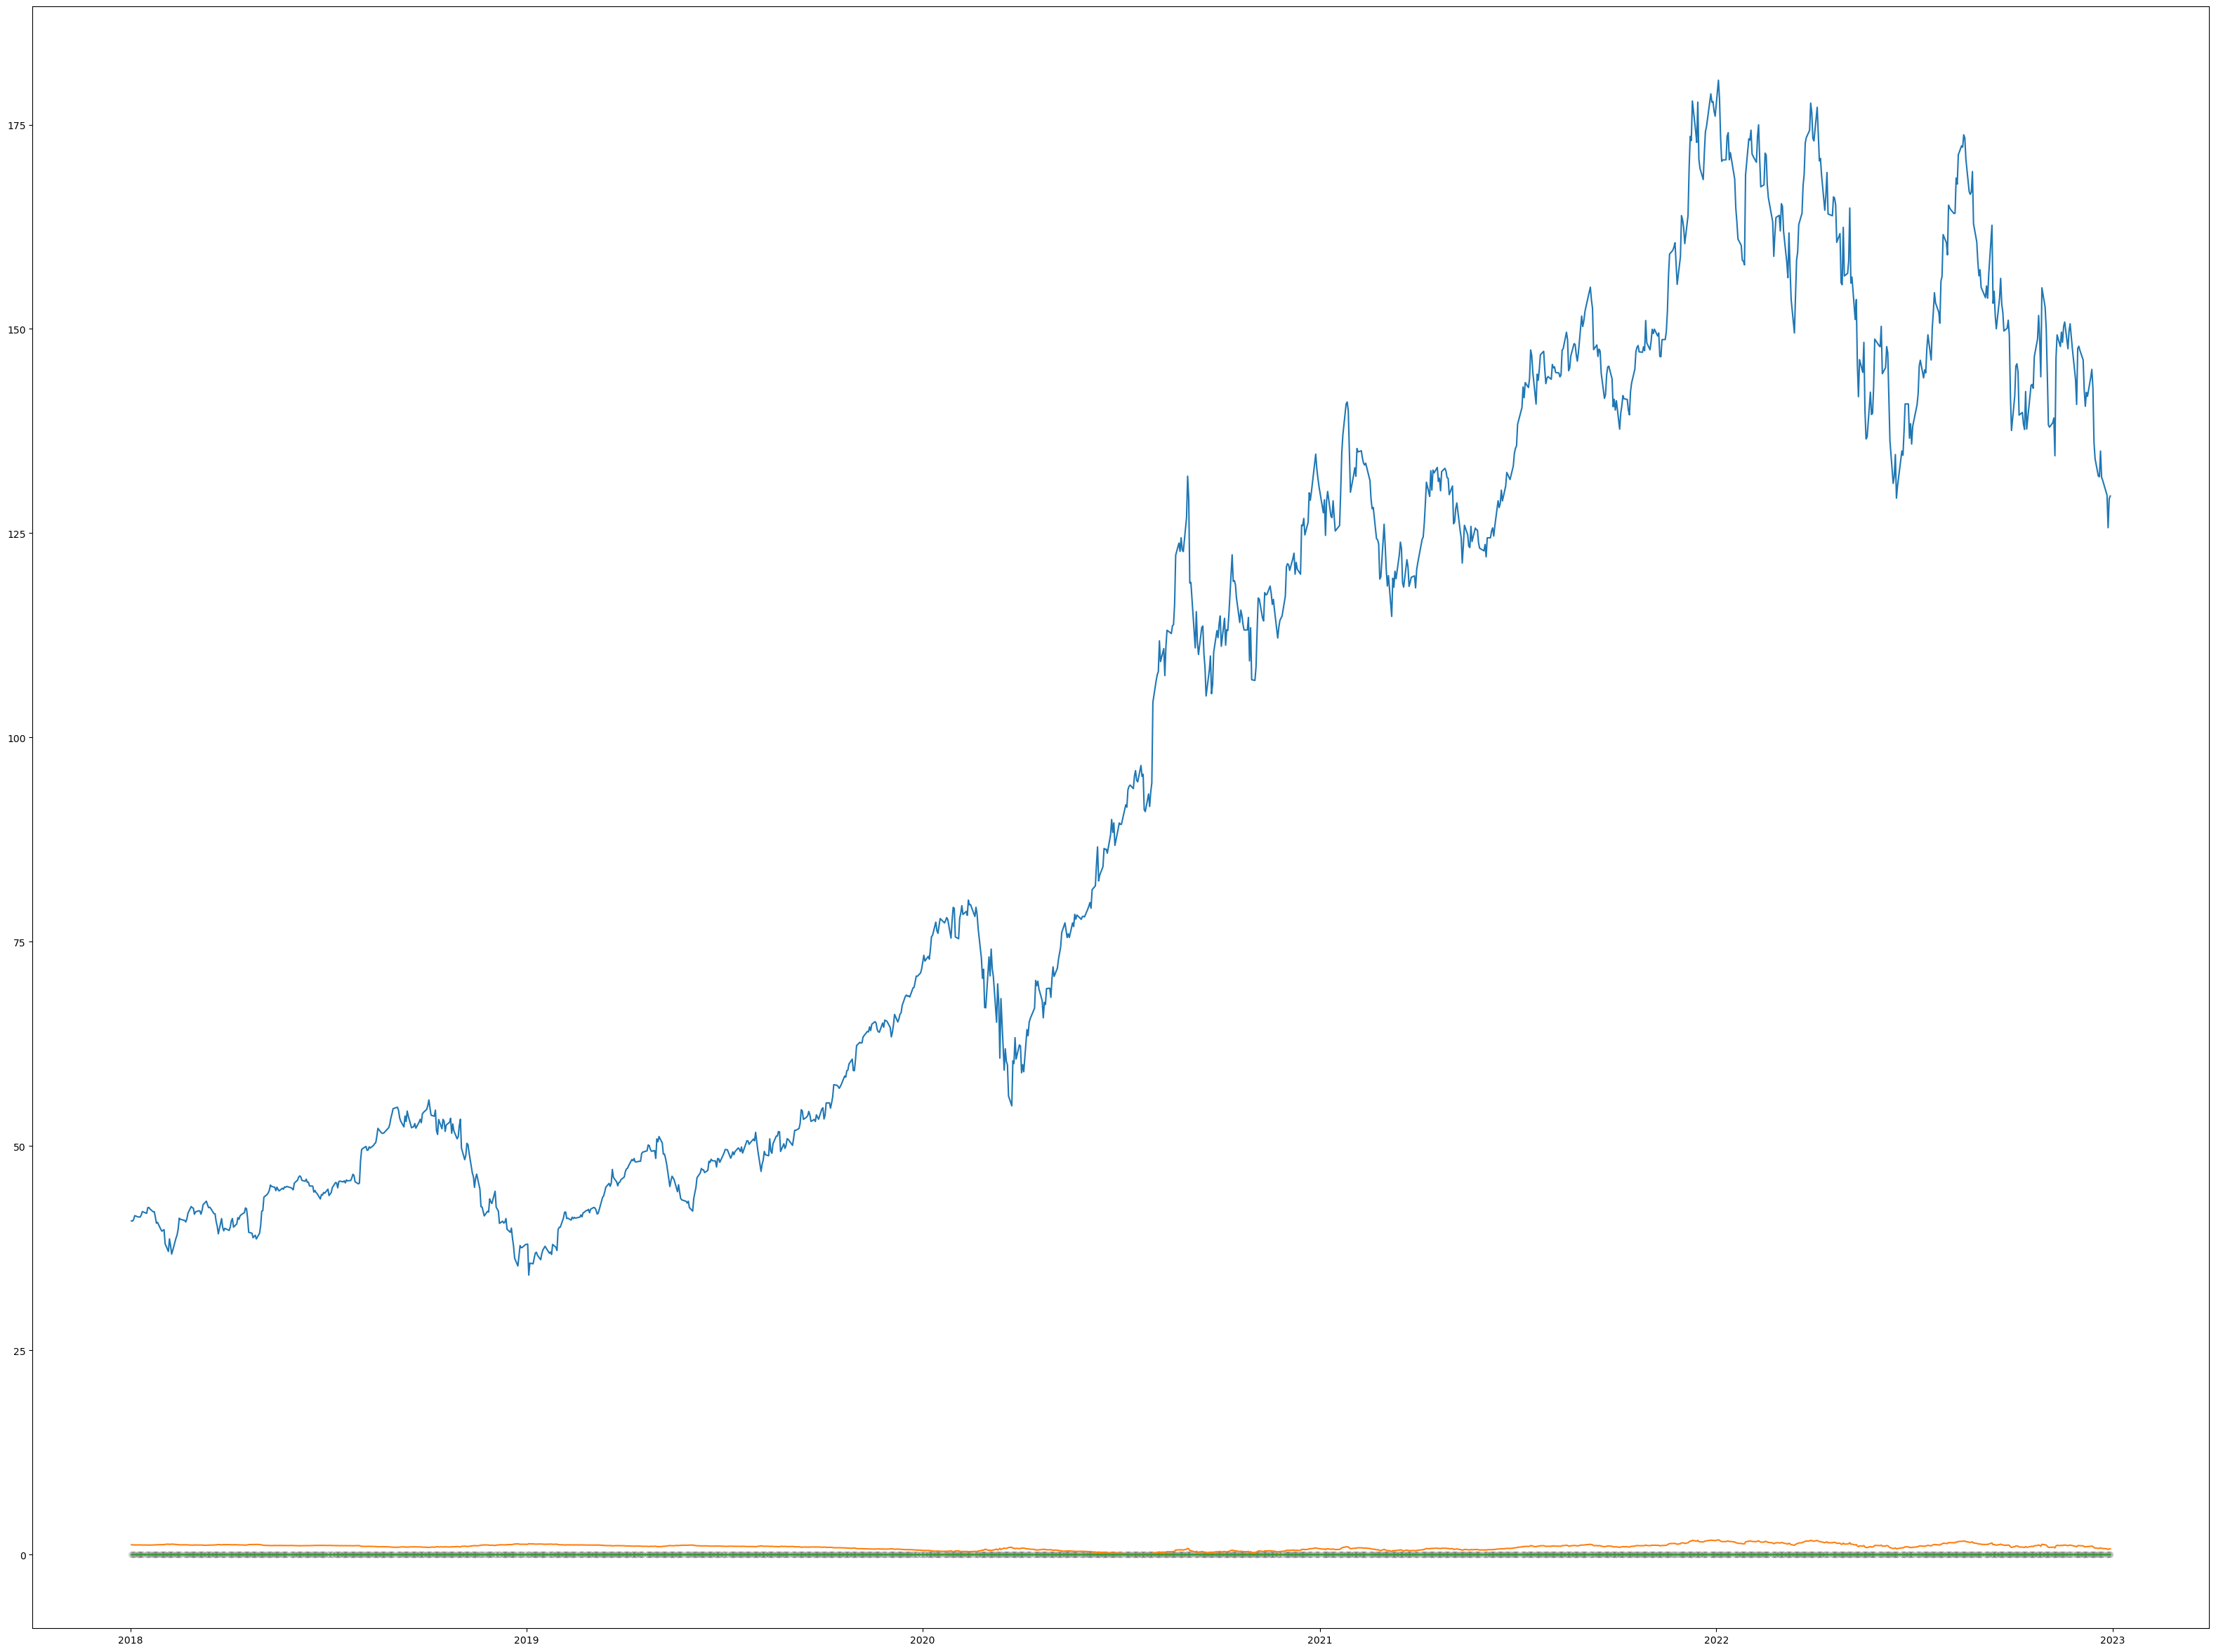

In [7]:
plt.figure(figsize=(40,30))
plt.plot(df.index, df, label='Adj Close')
plt.scatter(df['outlier'].index, df['outlier'], color='black', label='Outliers',alpha=.1)
plt.show()

In [8]:
#df = df[~df['outlier']]
#df

So here we have removed all the rows in which we were getting true values for outliers.

In [9]:
df=df.drop('outlier',axis=1)
df=df.drop('z_score',axis=1)
df

,Adj Close
Date,
2018-01-02,40.831589
2018-01-03,40.824474
2018-01-04,41.014107
2018-01-05,41.481060
2018-01-08,41.326996
...,...
2022-12-23,131.477127
2022-12-27,129.652435
2022-12-28,125.674026


In [35]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

df['Adj Close'].index = pd.DatetimeIndex(df['Adj Close'].index)
aapl_decomposed = sm.tsa.seasonal_decompose(df['Adj Close'], model='additive', period=7)

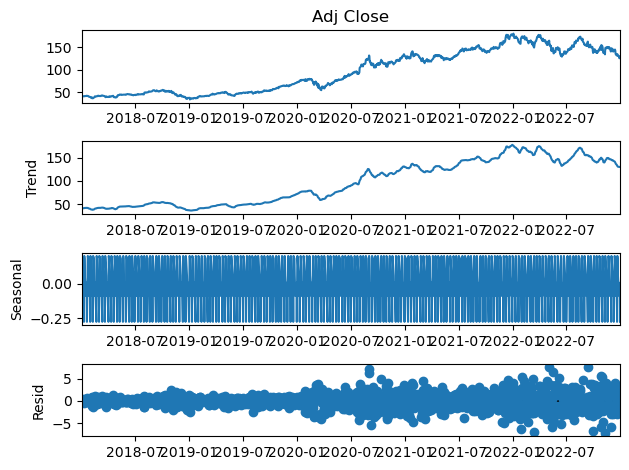

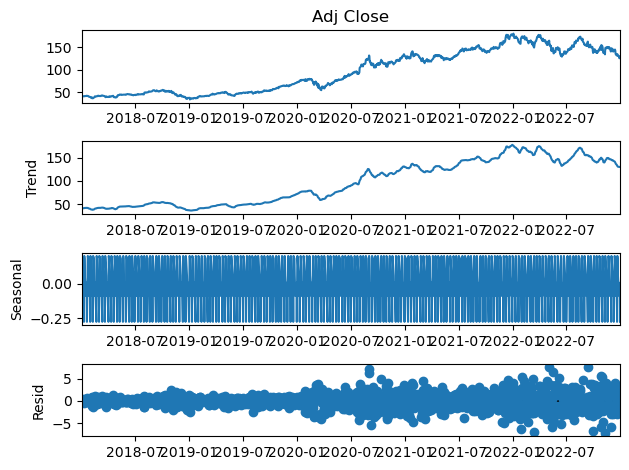

In [36]:
aapl_decomposed.plot()

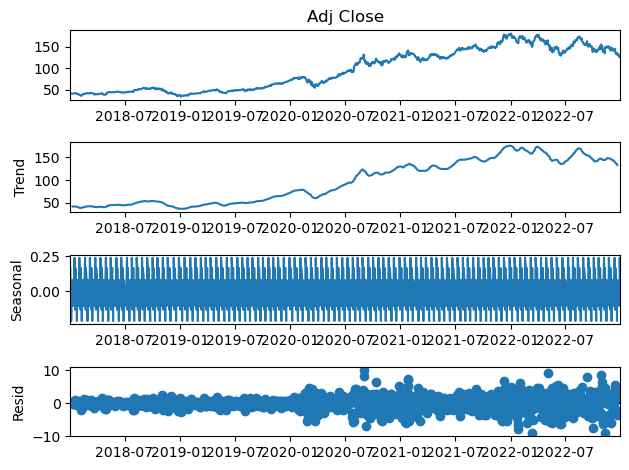

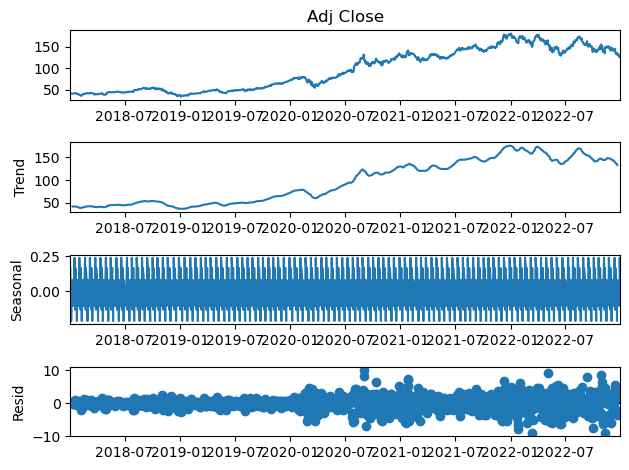

In [37]:
df['Adj Close'].index = pd.DatetimeIndex(df['Adj Close'].index)
aapl_decomposed = sm.tsa.seasonal_decompose(df['Adj Close'], model='additive', period=12)

aapl_decomposed.plot()

Here we have decomposed the data using an additive model. Now we will decompose the data using a multiplicative model.

Here we have plotted the decomposed data with 2 different periods which are 7 and 12 respectively. The period of 7 basically signifies the period of 7 days and tells its seasonality and the period of 12 signifies the period of 12 months and tells about its seasonality. Further, we believe that the additive model should be used for the decomposition of the stock price as generally there wont be a change in the seasonality even when the stock prices rise.

Apart from this, by looking at the graphs, we can analyse that overall there has been an upward trend. Till about around 1987, the residual values used to be very clustered arounf 0 but later, they have started to scatter a bit more. This can be due to the fact that after 1987, the volitility has increased in the stock price and the chart has started to higher highs and lower lows. Overall, the seasonal component shows the seasonality effect and the repeating pattern of highs and lows which is still seen.

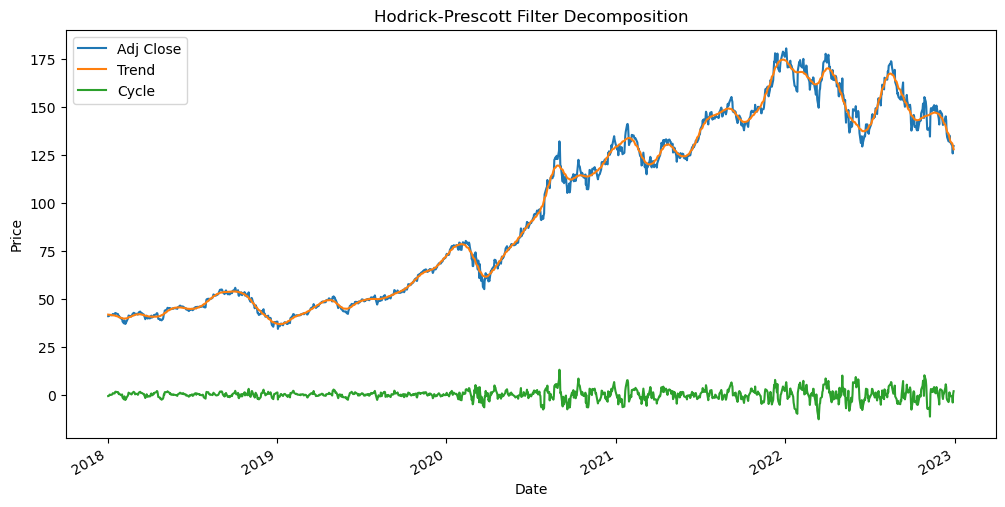

In [13]:
cycle, trend = sm.tsa.filters.hpfilter(df['Adj Close'])

df['Trend'] = trend
df['Cycle'] = cycle

df[['Adj Close', 'Trend', 'Cycle']].plot(figsize=(12, 6))

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Hodrick-Prescott Filter Decomposition')
plt.legend()

plt.show()

Here, again we have used a built in function of the stastmodel to find the data after the HP filter has been applied. Later we had stored the values of the 2 components, 'trend' and 'cyclic' into 2 different columns of the dataframe.

Basically, the HP filter assumes that the observed time series can be represented as the sum of a trend component and a cyclical component. The trend component represents the underlying smooth trend or growth rate of the series, while the cyclical component captures the short-term fluctuations around this trend.

So, if we add the 2 columns of 'trend' and 'cyclic', we are most likely supposed to get the column of 'Adj Close' again. 

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

<Axes: ylabel='Frequency'>

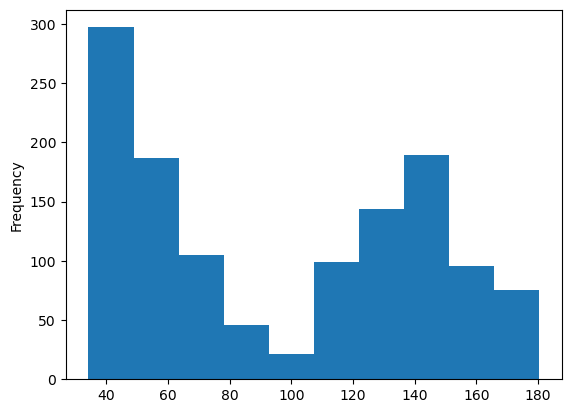

In [15]:
df['Adj Close'].plot(kind='hist')

In [16]:
def print_results(output,test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

In [20]:
adf_output = adfuller(df['Adj Close'])


In [21]:
kpss_output = kpss(df['Adj Close'])

C:\Users\91941\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [23]:
pd.concat([
    print_results(adf_output,'adf'),
    print_results(kpss_output,'kpss')
],axis=1)

,adf,kpss
Test Statistic,-1.063803,5.516963
p-value,0.729289,0.01
Numbers of lags,11,21
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.435605,0.739
Critical Value (5%),-2.863861,0.463
Critical Value (10%),-2.568005,0.347
Critical Value (2.5%),NaN,0.574


So basically, here we have got the p-value for adf as .72 while the p value for kpss method as .01. Now according to null hypothesis, we consider a value as null if it is less then .05. So here, we cant reject the p-value of adf, but we can reject the p-value of kpss.
Also, in the warning, it is given that the actual p-values were even smaller then thr p-values that have been returned.

We can say that the times series are not stationary.

In [30]:
def check_stationarity(df):
    kps = kpss(df['Adj Close'])
    adf = adfuller(df['Adj Close'])
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-Stationary'
    
    if adf_pv < 0.05:
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

In [31]:
check_stationarity(df)

C:\Users\91941\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


('Non Stationary', 'Non-Stationary')

In [49]:
def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(52).mean().plot(ax=ax[v,r], legend=False)

Here, we have defined 2 functions. The first function checks whether a time series is stationary or not. The second function takes a list of methods and compares their plots and calls the check_stationarity function to capture the results for the subplot titles.